In [158]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import utm

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score, mean_squared_error, classification_report

import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Input, Activation, concatenate
from keras.callbacks import History
from keras.models import Model

# The values have around 15 decimals, so for more clarity in reading we're increasing the number of displayed values
pd.set_option('display.float_format', '{:.15f}'.format)

# 1. Importing the data

In [120]:
sensor_and_loc_file = '../data/Processed/full_sensor_data_no_interpol_and_location.csv'

In [121]:
df_sensor_and_loc = pd.read_csv(sensor_and_loc_file, index_col=0)
df_sensor_and_loc.head(60)

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:51:61,0.412078860000000,0.443542480000000,9.409470000000001,0.032653810000000,0.321075440000000,-0.377655030000000,NaN,NaN,NaN,9.428927012090160,0.496768589146909,NaN,NaN,NaN
12:15:51:62,0.378555300000000,0.465087900000000,9.435805999999999,0.018798828000000,0.324279800000000,-0.366989140000000,NaN,NaN,NaN,9.454842449217251,0.490093678290338,NaN,NaN,NaN
12:15:51:63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12:15:51:64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12:15:51:65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12:15:51:66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12:15:51:67,0.826263400000000,0.764358500000000,9.596221999999999,0.096572876000000,0.284866330000000,-0.356338500000000,NaN,NaN,NaN,9.662009718272166,0.466317781055827,NaN,NaN,NaN
12:15:51:68,0.752044700000000,0.659011840000000,9.081467000000000,0.064605710000000,0.363693240000000,-0.362731930000000,52.499389999999998,-50.399780000000000,-261.300659999999993,9.136351060907591,0.517707565743274,271.245937648577694,NaN,NaN
12:15:51:69,0.651489260000000,0.623107900000000,8.861205999999999,-0.021682740000000,0.496841430000000,-0.363800050000000,NaN,NaN,NaN,8.906945238709721,0.616175319335621,NaN,NaN,NaN


In [122]:
df_sensor_and_loc.loc[:, 'lat'].interpolate(method='linear', inplace=True)
df_sensor_and_loc.loc[:, 'long'].interpolate(method='linear', inplace=True)
df_sensor_and_loc.dropna(inplace=True)
df_sensor_and_loc.shape

(31074, 14)

In [123]:
# Each 20 ms
df_sensor_and_loc.head(10)

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:51:68,0.752044700000000,0.659011840000000,9.081467000000000,0.064605710000000,0.363693240000000,-0.362731930000000,52.499389999999998,-50.399780000000000,-261.300659999999993,9.136351060907591,0.517707565743274,271.245937648577694,44.434937499999961,26.047602129736543
12:15:51:70,0.764022800000000,0.639862060000000,8.693603500000000,-0.093048096000000,0.537323000000000,-0.366989140000000,53.250121999999998,-49.650573999999999,-260.699459999999988,8.750536904096773,0.657308894946786,270.675014428439624,44.434937499999954,26.047602287170676
12:15:51:72,0.761627200000000,0.601547240000000,8.547561999999999,-0.231536870000000,0.496841430000000,-0.382980350000000,53.700256000000003,-51.600647000000002,-261.000060000000019,8.602485176829743,0.668681297196179,271.417345770840086,44.434937499999947,26.047602444604813
12:15:51:75,1.024993900000000,0.424377440000000,9.782973999999999,-0.580947900000000,0.266754150000000,-0.371261600000000,54.600524999999998,-48.300170000000001,-260.850520000000017,9.845673617954953,0.739251929108875,270.845191089993193,44.434937499999933,26.047602680756018
12:15:51:76,0.986679100000000,0.407623300000000,10.673614499999999,-0.573486300000000,0.265686040000000,-0.366989140000000,55.050660000000001,-50.250244000000002,-259.649659999999983,10.726869948670483,0.730860203470206,270.136276954078710,44.434937499999926,26.047602759473087
12:15:51:78,0.431228640000000,0.283126830000000,11.054290999999999,-0.396652220000000,0.280593870000000,-0.282836900000000,55.799866000000002,-49.049377000000000,-261.599730000000022,11.066321360529120,0.562194464143961,271.944636214393825,44.434937499999918,26.047602916907220
12:15:51:80,0.558120700000000,0.364532470000000,10.486862000000000,-0.098373410000000,0.309356700000000,-0.109207150000000,55.200195000000001,-48.599243000000001,-260.249329999999986,10.508028228192805,0.342498317136071,270.441604997566856,44.434937499999911,26.047603074341357
12:15:51:83,1.230896000000000,0.994201660000000,8.537979000000000,0.072067260000000,0.193252560000000,0.019699097000000,55.200195000000001,-48.599243000000001,-260.249329999999986,8.683353459810544,0.207191448503737,270.441604997566856,44.434937499999897,26.047603310492562
12:15:51:85,1.467910800000000,1.331787100000000,8.006470000000000,-0.067489624000000,-0.018737793000000,-0.014389038000000,56.550600000000003,-47.999572999999998,-262.350459999999998,8.248150147601766,0.071505235114204,272.634724917340520,44.434937499999890,26.047603467926695


## 1.1. Creating x and y

In [124]:
# df_sensor_and_loc['x'] = np.nan
# df_sensor_and_loc['y'] = np.nan
# for i in range(len(df_sensor_and_loc)):
#     lat = df_sensor_and_loc['lat'].iloc[i]
#     long = df_sensor_and_loc['long'].iloc[i]
#     df_sensor_and_loc['x'].iloc[i], df_sensor_and_loc['y'].iloc[i], zone, ut = utm.from_latlon(df_sensor_and_loc['lat'].iloc[i], df_sensor_and_loc['long'].iloc[i])
# df_sensor_and_loc

In [125]:
# plt.scatter(x=df_sensor_and_loc['x'], y=df_sensor_and_loc['y'])

In [126]:
# ::5 - each 100ms, ::10 -- each 200 ms
data = df_sensor_and_loc.copy(deep=True)[::5]
# data = data.iloc[:(len(data)//3), :]
print(data.shape)
print(data.head(10))

(6215, 14)
                           ax                 ay                 az  \
12:15:51:60 0.558120700000000  0.496215820000000  9.361587999999999   
12:15:51:76 0.986679100000000  0.407623300000000 10.673614499999999   
12:15:51:87 1.343414300000000  1.456283600000000  8.241104000000000   
12:15:51:96 1.092025800000000  1.726821900000000  9.117386000000000   
12:15:52:07 1.060897800000000  1.839355500000000 10.173218000000000   
12:15:52:17 1.039352400000000  1.180954000000000 10.731064000000000   
12:15:52:27 0.146316530000000 -0.353729250000000 11.063858000000000   
12:15:52:37 1.063293500000000  0.426773070000000 10.632904000000000   
12:15:52:47 0.246871950000000  0.060470580000000  8.296173000000000   
12:15:52:57 0.622756960000000  0.295089720000000  9.160477000000000   

                            gx                 gy                 gz  \
12:15:51:60  0.074188230000000  0.290191650000000 -0.387237550000000   
12:15:51:76 -0.573486300000000  0.265686040000000 -0.3669891400

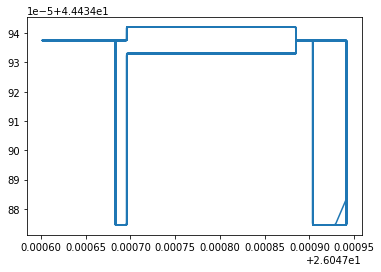

In [127]:
plt.plot(data['long'], data['lat'])

In [128]:
# plt.plot(data['x'], data['y'])

# 2. Creating the LSTM model

## 2.1. Scaling the data

In [129]:
backcandles=100

sc_attributes = MinMaxScaler(feature_range=(-1, 1))
attributes_scaled = sc_attributes.fit_transform(data.iloc[:, :-2])

sc_targets = MinMaxScaler(feature_range=(0, 1))
targets_scaled = sc_targets.fit_transform(data.iloc[backcandles:, [-2, -1]])
# y_test_1 = data.iloc[:, [-2, -1]]
# print(y_test_1)
# y_test_sc = sc.fit_transform(data.iloc[:, [-2, -1]])
# print(data_scaled)

In [130]:
print(attributes_scaled.shape[0], attributes_scaled.shape[1], targets_scaled.shape)

6215 12 (6115, 2)


## 2.2. Principal Component Analysis (PCA)

In [131]:
# Apply PCA with 90% desired components
pca = PCA(0.99)
X_pca = pca.fit_transform(attributes_scaled)
X_pca.shape

(6215, 10)

In [132]:
# pca.fit_transform(attributes_scaled)

## 2.2. Reshaping the data in order to feed it to the model

In [133]:
# The following cell does this:

# []
# i = 0
# X = [[]]
# for j in range(30, 8611)
#     J = 30
#     X[0].append(data_scaled[30-30=0:30, 0]) --> append and array
#     J = 31
#     X[0].append(31-30=1:31, 0)
#     
# i = 1
# X = [
#       [  <-- 12 of those
#        [5.5811, 5.4786, .., 5.1232  <--- 30 (backcandles) of those], [], ..., [] <--- 8581 of those
#       ],
#      [
#        [5.5811, 5.4786, .., 5.1232], [], ..., []
#      ]
#    ]   ---> 
# for j in range(30, 8611)
#     X[0].append(data_scaled[30-30:30, 0])

In [134]:
X = []
backcandles=backcandles # number of last values to look into

for i in range(X_pca.shape[1]): #number of attributes columns
    X.append([])
    for j in range(backcandles, attributes_scaled.shape[0]):
        X[i].append(attributes_scaled[j-backcandles:j, i])
        
# move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

# We need shape (8581, 30, 12) = (rows, val of past attributes, columns) for LSTM training
X.shape

(6115, 100, 10)

In [135]:
# Transform X and the targets (lat and long columns) into arrays so the axis can be moved and the data 
# to be used in the LSTM model
X, y = np.array(X), np.array(targets_scaled)

# Move the axis for yi, so instead of (8581, 2) we'll have (8581, 1, 2)
# I HAVE MODIFIED THIS:
# y = np.reshape(yi,(len(yi), 1, 2))
# y = np.reshape(yi,(len(yi), 2))

print('X Shape: ',X.shape)
print('y shape: ', y.shape)
targets_scaled

X Shape:  (6115, 100, 10)
y shape:  (6115, 2)


array([[0.86857167, 0.24055327],
       [0.86222246, 0.24055327],
       [0.85587326, 0.24055327],
       ...,
       [0.93333312, 0.00839689],
       [0.93333312, 0.00530971],
       [0.93333312, 0.00222253]])

## 2.3. Split the data into train, test and validation sets

In [136]:
splitlimit_test = int(len(X) * 0.7)
splitlimit_val = int(len(X) * 0.9)

print(splitlimit_test, splitlimit_val)
X_train, X_test, X_val = X[:splitlimit_test], X[splitlimit_test:splitlimit_val], X[splitlimit_val:]
y_train, y_test, y_val = y[:splitlimit_test], y[splitlimit_test:splitlimit_val], y[splitlimit_val:]
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

4280 5503
(4280, 100, 10)
(1223, 100, 10)
(612, 100, 10)
(4280, 2)
(1223, 2)
(612, 2)


## 2.4. Creating the LSTM  model

### 2.4.1. Create function to plot the training

In [137]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

### 2.4.2. Parametrizing the model

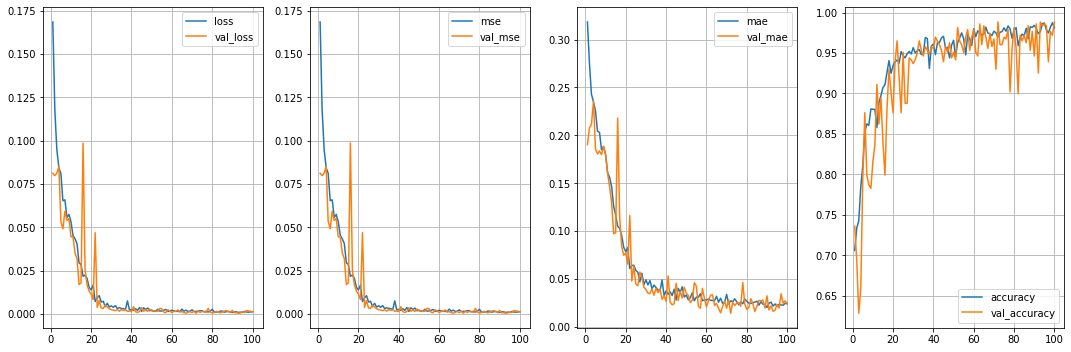

39/39 [==============================] - 23s 586ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0247 - accuracy: 0.9810 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0239 - val_accuracy: 0.9883


In [174]:
attributes_cols = X_pca.shape[1]
batch_size=100
epochs=100

lstm_input = Input(shape=(backcandles, attributes_cols), name='lstm_input')
# TODO: don't use relu here, it went bad
inputs = LSTM(128, name='first_layer', return_sequences=True)(lstm_input)
# inputs = Dropout(0.2)(inputs)
inputs = LSTM(64, name='second_layer', return_sequences=False)(inputs)
# inputs = Dropout(0.2)(inputs)
inputs = Dense(2, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()

model.compile(optimizer=RMSprop(learning_rate=0.005), loss='mse', metrics=['mse', 'mae', 'accuracy'])
model.fit(x=X_train, 
          y=y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          shuffle=False, 
          validation_split=0.1,
          callbacks=[PlotLearning()])

# model = Sequential()
# model.add(LSTM(128, activation='relu', name='first_layer', return_sequences=True))
# model.add(LSTM(128, activation='relu', name='second_layer', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(2, name='dense_layer'))
# model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# model.fit(X_train, y_train, epochs=epochs)

In [175]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])
len(y_pred), len(y_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

39/39 [==============================] - 6s 74ms/step
[0.8967639  0.21219903] [0.93333317 0.19304129]
[0.8939314  0.21063116] [0.93333317 0.19211513]
[0.89640296 0.21325354] [0.93333317 0.19091113]
[0.89721787 0.21213293] [0.93333317 0.18998497]
[0.89398336 0.2124643 ] [0.93333317 0.18915144]
[0.8940829  0.21261874] [0.93333317 0.18822528]
[0.89793766 0.2076214 ] [0.93333317 0.18729913]
[0.9023622  0.20149043] [0.93333317 0.18637297]
[0.90416455 0.19673184] [0.93333317 0.1853542 ]
[0.9074229 0.1926605] [0.93333317 0.18292562]
Mean Squared Error (MSE): 0.0015183953432079977
R-squared: 0.982784897265058


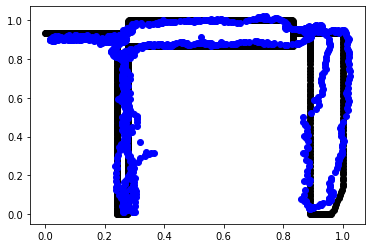

In [176]:
plt.scatter(y_test[:, 1], y_test[:, 0], color='black', label='Test')
plt.scatter(y_pred[:, 1], y_pred[:, 0], color='blue', label='Pred')

Mean Squared Error (MSE): 5.2952195281372487e-11
R-squared: 0.9787181730727484
[[44.4349375  26.04766721]
 [44.4349375  26.0476669 ]
 [44.4349375  26.04766649]
 ...
 [44.434933   26.04775736]
 [44.434933   26.04775909]
 [44.434933   26.04776098]] [[44.434937 26.047674]
 [44.434937 26.047672]
 [44.434937 26.047674]
 ...
 [44.434937 26.047747]
 [44.434937 26.047747]
 [44.434937 26.047749]]


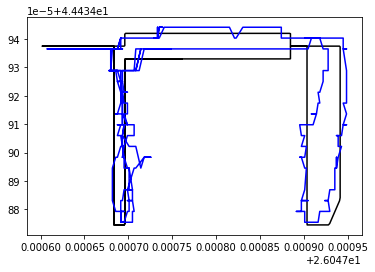

In [177]:
y_test_normalized = sc_targets.inverse_transform(y_test)
y_pred_normalized = sc_targets.inverse_transform(y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_normalized, y_pred_normalized)
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared
r2 = r2_score(y_test_normalized, y_pred_normalized)
print("R-squared:", r2)

plt.plot(y_test_normalized[:, 1], y_test_normalized[:, 0], color='black', label='Test')
plt.plot(y_pred_normalized[:, 1], y_pred_normalized[:, 0], color='blue', label='Pred')
print(y_test_normalized, y_pred_normalized)

In [178]:
model.evaluate(X_test, y_test)

39/39 [==============================] - 3s 68ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0278 - accuracy: 0.9648


[0.0015183957293629646,
 0.0015183957293629646,
 0.027845006436109543,
 0.9648405313491821]

In [179]:
from math import radians, cos, sin, asin, acos, sqrt, pi
import geopy.distance

def calculate_spherical_distance(row):
    " Calculates the distance in km with the haversine method, which assumes the earth is sphere"
    lat1 = row['lat1']
    lon1 = row['long1']
    lat2 = row['lat2']
    lon2 = row['long2']
    r=6371
    # Convert degrees to radians
    coordinates = lat1, lon1, lat2, lon2
    phi1, lambda1, phi2, lambda2 = [
        radians(c) for c in coordinates
    ]
    
    # Apply the haversine formula
    d = r*acos(cos(phi2-phi1) - cos(phi1) * cos(phi2) *
              (1-cos(lambda2-lambda1)))
    return d

def calculate_vincenty_distance(row):
    coords_1 = (row['lat1'], row['long1'])
    coords_2 = (row['lat2'], row['long2'])
    
    return geopy.distance.geodesic(coords_1, coords_2).km

In [180]:
y_pred_step_2 = pd.DataFrame(y_pred_normalized, columns=['lat1', 'long1'])
y_test_step_2 = pd.DataFrame(y_test_normalized, columns=['lat2', 'long2'])

# alculating the Euclidian distance between points
distance_df = pd.DataFrame((y_test_step_2['lat2']-y_pred_step_2['lat1'])**2 + 
                           (y_test_step_2['long2']-y_pred_step_2['long1'])**2)**(1/2)
sum_dist = distance_df.sum()
mean_error = sum_dist/len(distance_df)
mean_error

0   0.000008577325942
dtype: float64

In [181]:
df_final = pd.DataFrame()
df_final = pd.concat([y_pred_step_2, y_test_step_2], axis=1)

df_final['km_difference_haversine'] = df_final.apply(calculate_spherical_distance, axis=1)
df_final['m_difference_haversine'] = df_final['km_difference_haversine']*1000

df_final['km_difference_vincenty'] = df_final.apply(calculate_vincenty_distance, axis=1)
df_final['m_difference_vincenty'] = df_final['km_difference_vincenty']*1000

# Mean Squared Error Haversine
mse_h = (df_final['m_difference_haversine']*df_final['m_difference_haversine']).sum()/len(df_final)
print(f'Mean Squared error for Haversine is: {mse_h} m')

# Mean Squared Error Vincenty
mse_v = (df_final['m_difference_vincenty']*df_final['m_difference_vincenty']).sum()/len(df_final)
print(f'Mean Squared error for Vincenty is: {mse_v} m')

df_final

Mean Squared error for Haversine is: 0.7475686195205526 m
Mean Squared error for Vincenty is: 0.7515843397914006 m


,lat1,long1,lat2,long2,km_difference_haversine,m_difference_haversine,km_difference_vincenty,m_difference_vincenty
0,44.434936523437500,26.047674179077148,44.434937499968171,26.047667212924928,0.000561644796999,0.561644796999211,0.000565146307968,0.565146307968422
1,44.434936523437500,26.047672271728516,44.434937499968157,26.047666898056658,0.000435048189052,0.435048189052398,0.000441387302102,0.441387302102485
2,44.434936523437500,26.047674179077148,44.434937499968136,26.047666488727906,0.000615251049244,0.615251049243756,0.000621831109296,0.621831109296102
3,44.434936523437500,26.047674179077148,44.434937499968115,26.047666173859636,0.000643882517852,0.643882517851757,0.000646530421408,0.646530421408167
4,44.434936523437500,26.047674179077148,44.434937499968100,26.047665890478189,0.000664547085762,0.664547085762024,0.000668783336506,0.668783336506135
...,...,...,...,...,...,...,...,...
1218,44.434936523437500,26.047742843627930,44.434933003383740,26.047754211093647,0.000982018358071,0.982018358071092,0.000985962760997,0.985962760997443
1219,44.434936523437500,26.047742843627930,44.434933003383648,26.047755785434880,0.001098955525572,1.098955525572250,0.001102145068590,1.102145068589673
1220,44.434936523437500,26.047746658325195,44.434933003383563,26.047757359776121,0.000935004250038,0.935004250038311,0.000937523466014,0.937523466013904
1221,44.434936523437500,26.047746658325195,44.434933003383470,26.047759091551480,0.001061408898581,1.061408898580907,0.001064385799412,1.064385799412394
